In [1]:
import polars as pl
from polars import col
from bill_law_similarity.vector import preprocess, compute_cosine_similarity
from bill_law_similarity.docu_toads import docu_toads_similarity
from bill_law_similarity.bow import bow_overlap, bow_pos_overlap
from bill_law_similarity.string_diff import diff
from bill_law_similarity.deep import BertSimilarity
from bill_law_similarity.string_diff import sw_align
from bill_law_similarity.main import load_df, comparison_wrapper, pos_bow_ol_wrapper, similarity_metrics
import jaro

%load_ext autoreload
%autoreload 2

/home/peter/anaconda3/envs/billlaw/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_en = load_df("test", "en")
test_de = load_df("test", "de")

100%|██████████| 944/944 [00:25<00:00, 37.35it/s]


In [53]:
from bill_law_similarity.gzip_knn import compression_similarity, compression_similarity_array


gzip_en = test_en.with_columns(
    comparison_wrapper(
                "bill_lemmas", "law_lemmas",compression_similarity_array, "gzip_lemma"),
    comparison_wrapper(
                "bill_text", "law_text",compression_similarity, "gzip_text"),
)
gzip_de = test_de.with_columns(
       comparison_wrapper(
                "bill_lemmas", "law_lemmas",compression_similarity_array, "gzip_lemma"),
    comparison_wrapper(
                "bill_text", "law_text",compression_similarity, "gzip_text"),
)

In [2]:
def pipeline(lang, to_csv=True):
    train = load_df("train", lang)
    train = similarity_metrics(train)
    
    val = load_df("val", lang).sample(10)
    val = similarity_metrics(val)
    
    test = load_df("test", lang)
    test = similarity_metrics(test)
    try:
        if to_csv:
            val.write_csv(f"data/results/val_metrics_{lang}.csv")
            train.write_csv(f"data/results/train_metrics_{lang}.csv")
            test.write_csv(f"data/results/test_metrics_{lang}.csv")
    except: 
        return train, val, test
    return train, val, test

In [54]:
# train_metrics_de, val_metrics_de, test_metrics_de = pipeline("de")
train_metrics_de = pl.read_csv("data/results/train_metrics_de.csv")
val_metrics_de = pl.read_csv("data/results/val_metrics_de.csv")
test_metrics_de = pl.read_csv("data/results/test_metrics_de.csv")

In [55]:
# train_metrics_en, val_metrics_en, test_metrics_en = pipeline("en")
train_metrics_en = pl.read_csv("data/results/train_metrics_en.csv")
val_metrics_en = pl.read_csv("data/results/val_metrics_en.csv")
test_metrics_en = pl.read_csv("data/results/test_metrics_en.csv")

In [58]:
test_metrics_en = test_metrics_en.with_columns(
    pl.Series(gzip_en["gzip_text"]).alias("gzip_text"),
    pl.Series(gzip_en["gzip_lemma"]).alias("gzip_lemma")
)
test_metrics_de = test_metrics_de.with_columns(
        pl.Series(gzip_en["gzip_text"]).alias("gzip_text"),
    pl.Series(gzip_en["gzip_lemma"]).alias("gzip_lemma")
)
    

In [59]:
test_de = load_df("test", "de", preprocessing=False).with_columns([
    pl.col("label") / 4
])
test_en = load_df("test", "en", preprocessing=False).with_columns([
    pl.col("label") / 4
])

In [60]:
paper_pred_de = pl.read_csv("data/predictions/test_preds_de.csv")
paper_pred_en = pl.read_csv("data/predictions/test_preds_en.csv")
test_metrics_de = test_metrics_de.with_columns([
    pl.Series(paper_pred_de["paper_preds"]/4).alias("bert_paper"),
])
test_metrics_en = test_metrics_en.with_columns([
    pl.Series(paper_pred_en["paper_preds"] /4).alias("bert_paper"),
])

In [17]:
test_en["label"].describe()

statistic,value
str,f64
"""count""",944.0
"""null_count""",0.0
"""mean""",0.340837
"""std""",0.395022
"""min""",0.0
"""max""",1.0
"""median""",0.0
"""25%""",0.0
"""75%""",0.75


In [61]:
# spearman correlation
from scipy.stats import spearmanr

def evaluate_spearmanr(test_metrics, labels):
    results = []
    for col in test_metrics.columns:
        corr = spearmanr(test_metrics[col], labels)
        results.append((col, corr.correlation))
    return pl.DataFrame(results, schema=["method", "corr"]).sort(by="corr",descending=False)

In [63]:
eval_en = evaluate_spearmanr(test_metrics_en, test_en["label"])

Text(0.5, 0, 'Spearman Correlation')

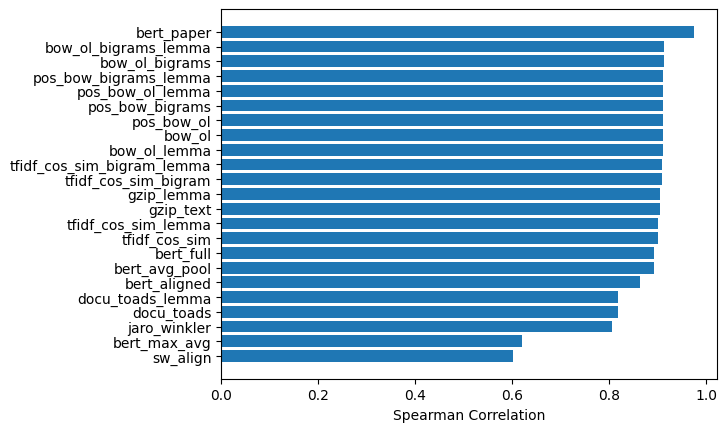

In [64]:
from matplotlib import pyplot as plt
plt.barh(eval_en["method"].to_numpy(), eval_en["corr"].to_numpy())
plt.xlabel("Spearman Correlation")


In [65]:
eval_de = evaluate_spearmanr(test_metrics_de, test_de["label"])

In [67]:
eval_de

method,corr
str,f64
"""bert_max_avg""",0.4386
"""sw_align""",0.602116
"""jaro_winkler""",0.80521
"""docu_toads""",0.818077
"""docu_toads_lem…",0.821657
"""bert_avg_pool""",0.827851
"""bert_aligned""",0.868763
"""bert_full""",0.892139
"""tfidf_cos_sim""",0.900146


Text(0.5, 0, 'Spearman Correlation')

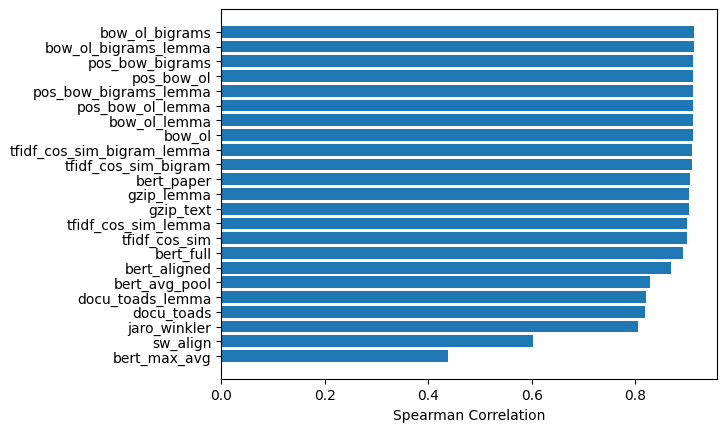

In [66]:
from matplotlib import pyplot as plt
plt.barh(eval_de["method"].to_numpy(), eval_de["corr"].to_numpy())
plt.xlabel("Spearman Correlation")

In [40]:
eval_en.write_csv("data/results/correlations_en.csv")
eval_de.write_csv("data/results/correlations_de.csv")

# Qualitative Evaluation

In [16]:
qeval = test_metrics_en[["pos_bow_bigrams_lemma", "bert_paper"]].with_columns([
    pl.Series(test_en["label"]).alias("label"),
    (pl.col("pos_bow_bigrams_lemma") - pl.col("bert_paper")).abs().alias("delta"),
    # index column
    pl.Series(list(range(0, len(test_metrics_en)))).alias("index"),
    pl.Series(test_en["bill_text"]).alias("bill_text"),
    pl.Series(test_en["law_text"]).alias("law_text"),
]).sort(by="delta", descending=True)
#qeval.write_json("data/results/qeval_en.json", row_oriented=True)

In [6]:

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# results = {}
# for col in train_metrics.columns:
#     clf = DecisionTreeClassifier(random_state=0, max_leaf_nodes=5)
#     clf.fit(train_metrics[col].to_numpy().reshape(-1, 1), train["label"].to_numpy())

#     y_pred = clf.predict(test_metrics[col].to_numpy().reshape(-1, 1))
#     labels = test["label"].to_numpy()
    
#     acc = accuracy_score(labels, y_pred)
#     f1 = f1_score(labels, y_pred, average="macro")
#     precision = precision_score(labels, y_pred, average="macro", zero_division=0)
#     recall = recall_score(labels, y_pred, average="macro")
#     results[col] = {
#         "metric": col,
#         "accuracy": acc,
#         "f1": f1,
#         "precision": precision,
#         "recall": recall,
#     }


    

In [300]:
results.values()

dict_values([{'accuracy': 0.7627118644067796, 'f1': 0.6208510684750875, 'precision': 0.6205473075931223, 'recall': 0.6216715381804896}, {'accuracy': 0.7436440677966102, 'f1': 0.5925509931821002, 'precision': 0.596103714123717, 'recall': 0.5900535866520521}, {'accuracy': 0.8114406779661016, 'f1': 0.6770380833354309, 'precision': 0.6817994165937874, 'recall': 0.6737078309584703}, {'accuracy': 0.8188559322033898, 'f1': 0.680153230783604, 'precision': 0.6807414561966956, 'recall': 0.6800864693703568}, {'accuracy': 0.6885593220338984, 'f1': 0.5465039303355419, 'precision': 0.54587128059086, 'recall': 0.5478254780172939}, {'accuracy': 0.746822033898305, 'f1': 0.6073215017775543, 'precision': 0.6101512790718022, 'recall': 0.6050213128729753}, {'accuracy': 0.7584745762711864, 'f1': 0.6123191406114158, 'precision': 0.6142585053659566, 'recall': 0.6111332359030569}, {'accuracy': 0.7171610169491526, 'f1': 0.5835321186149145, 'precision': 0.5829854839250393, 'recall': 0.5846669102423578}, {'accura

In [7]:
pl.from_dicts(list(results.values()))

metric,accuracy,f1,precision,recall
str,f64,f64,f64,f64
"""bert_aligned""",0.777542,0.582825,0.598075,0.581134
"""bert_avg_pool""",0.792373,0.592757,0.589551,0.599291
"""bert_max_avg""",0.662076,0.450413,0.554102,0.422731
"""bert_full""",0.791314,0.591546,0.575143,0.609746
"""tfidf_cos_sim""",0.806144,0.613613,0.612097,0.62867
"""sw_align""",0.602754,0.312034,0.370784,0.376812
"""docu_toads""",0.763771,0.539539,0.581896,0.543926
"""bow_ol""",0.824153,0.635002,0.618282,0.653091
"""pos_bow_ol""",0.820975,0.631337,0.627036,0.643845


EN

In [339]:
pl.from_dicts(list(results.values()))

metric,accuracy,f1,precision,recall
str,f64,f64,f64,f64
"""tfidf_cos_sim""",0.8125,0.61377,0.6003,0.628347
"""docu_toads""",0.831568,0.648159,0.647028,0.65282
"""bow_ol""",0.853814,0.657753,0.643068,0.680417
"""pos_bow_ol""",0.861229,0.670737,0.655576,0.688902
"""jaro_winkler""",0.753178,0.498827,0.476643,0.531014
"""bert_aligned""",0.808263,0.608551,0.603454,0.619411
"""bert_avg_pool""",0.8125,0.615658,0.611225,0.625742
"""bert_max_avg""",0.729873,0.528292,0.567965,0.514876
"""bert_full""",0.810381,0.607957,0.588911,0.633409


In [9]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import MarianMTModel, MarianTokenizer

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-de")
tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
translated = model.generate(**tokenizer(["wie geht es dir?"," asdas"], return_tensors="pt", padding=True))

In [ ]:
import itertools
a = ["We prefer environmental protection over economic growth", "We prefer economic growth over environmental protection", "We prefer climate change mitigation over economic performance", "We prefer economic performance over climate change mitigation"]
# combine every two sentences
b = list(itertools.combinations(a, 2))
example = pl.from_records(b, orient="row", schema=["bill_text", "law_text"])
example_pre = preprocess(example, "en")
pl.concat([example,similarity_metrics(example_pre)[:,10:]], how="horizontal")#.write_csv("christian_beispiel.csv")